In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
count = 0 
dirs = os.listdir("medical_mnist/")
for dir in dirs:
    file = list(os.listdir("medical_mnist/"+dir))
    print( dir + ' folder has ' + str(len(file)) + " images")
    count = count + len(file)
print("Image Folder has " + str(count) + " Images") 

AbdomenCT folder has 10000 images
BreastMRI folder has 8954 images
ChestCT folder has 10000 images
CXR folder has 10000 images
Hand folder has 10000 images
HeadCT folder has 10000 images
Image Folder has 58954 Images


In [3]:
base_dir = "medical_mnist/"
img_sz = 64
batch = 32
num = 6

In [4]:
dataset = image_dataset_from_directory(
    base_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_sz, img_sz),
    batch_size= batch,
    shuffle=True,
    seed=123
)

Found 58953 files belonging to 6 classes.


In [5]:
cls = dataset.class_names
print('Class names:', cls)

Class names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']


In [6]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

In [7]:
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)

In [8]:
for images, labels in train_ds.take(1):
    print(f"Train images shape: {images.shape}")
    print(f"Train labels shape: {labels.shape}")

for images, labels in val_ds.take(1):
    print(f"Validation images shape: {images.shape}")
    print(f"Validation labels shape: {labels.shape}")

for images, labels in test_ds.take(1):
    print(f"Test images shape: {images.shape}")
    print(f"Test labels shape: {labels.shape}")

Train images shape: (32, 64, 64, 3)
Train labels shape: (32,)
Validation images shape: (32, 64, 64, 3)
Validation labels shape: (32,)
Test images shape: (32, 64, 64, 3)
Test labels shape: (32,)


In [9]:
Autotune = tf.data.AUTOTUNE

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = Autotune)
val_ds = val_ds.cache().prefetch(buffer_size = Autotune)
test_ds = test_ds.cache().prefetch(buffer_size= Autotune)

In [11]:
train_dataset = train_ds.repeat()
val_dataset = val_ds.repeat()

In [12]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64 ,64 , 3))

In [13]:
for layer in base_model.layers:
    layer.trainable = False

In [14]:
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num, activation='softmax')(x)

model = Model(inputs= base_model.input, outputs=predictions)
model

<Functional name=functional, built=True>

In [15]:
model.compile(optimizer= "adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,766,854 (60.15 MB)

 Trainable params: 1,052,166 (4.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
history = model.fit(train_ds, epochs = 3, validation_data = val_ds,verbose=1)

Epoch 1/3
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 1133s 853ms/step - accuracy: 0.9778 - loss: 0.4311 - val_accuracy: 0.9952 - val_loss: 0.1906
Epoch 2/3
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 968s 750ms/step - accuracy: 0.9968 - loss: 0.1023 - val_accuracy: 0.9993 - val_loss: 0.0259
Epoch 3/3
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 1005s 779ms/step - accuracy: 0.9980 - loss: 0.0646 - val_accuracy: 0.9986 - val_loss: 0.0453


In [18]:
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')

185/185 ━━━━━━━━━━━━━━━━━━━━ 130s 622ms/step - accuracy: 0.9977 - loss: 0.1017
Test accuracy: 0.9976258873939514


In [19]:
model.evaluate(val_ds)

368/368 ━━━━━━━━━━━━━━━━━━━━ 219s 597ms/step - accuracy: 0.9987 - loss: 0.0301


[0.045339059084653854, 0.99855637550354]

In [20]:
val_preds = model.predict(val_ds)
val_preds

368/368 ━━━━━━━━━━━━━━━━━━━━ 194s 525ms/step


array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [21]:
val_labels = []
for images, labels in val_ds:
    labels = labels.numpy()
    val_labels.extend(labels)
val_labels = np.array(val_labels)
val_preds_classes = np.argmax(val_preds, axis=1)
for images, labels in val_ds.take(1):
    print(f"Labels shape: {labels.shape}")

Labels shape: (32,)


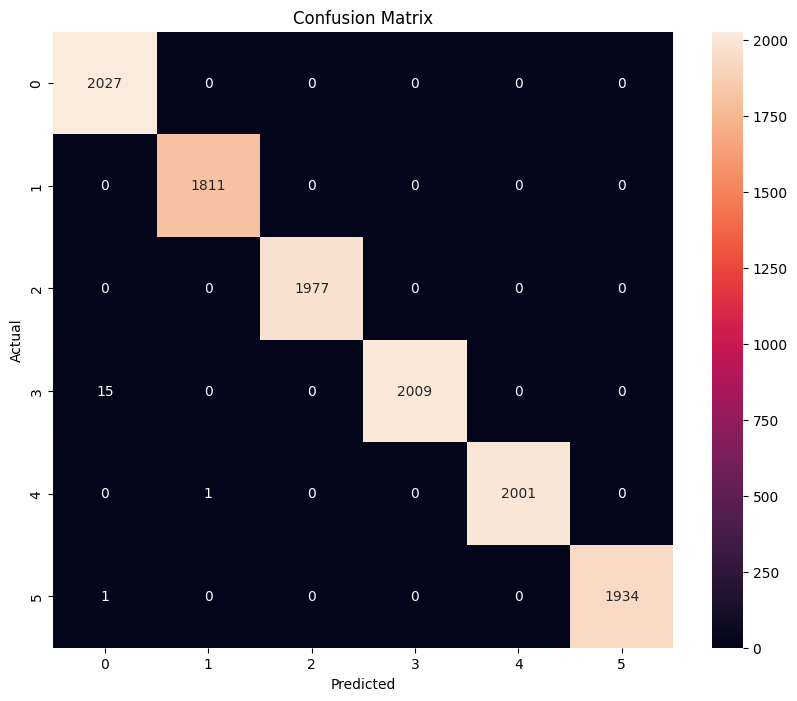

In [22]:
conf_matrix = confusion_matrix(val_labels, val_preds_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [23]:
class_report = classification_report(val_labels, val_preds_classes, target_names=cls)
print('Classification Report:\n', class_report)

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.99      1.00      1.00      2027
   BreastMRI       1.00      1.00      1.00      1811
         CXR       1.00      1.00      1.00      1977
     ChestCT       1.00      0.99      1.00      2024
        Hand       1.00      1.00      1.00      2002
      HeadCT       1.00      1.00      1.00      1935

    accuracy                           1.00     11776
   macro avg       1.00      1.00      1.00     11776
weighted avg       1.00      1.00      1.00     11776



In [24]:
test_preds = model.predict(test_ds)
test_preds_classes = np.argmax(test_preds, axis=1)

185/185 ━━━━━━━━━━━━━━━━━━━━ 95s 515ms/step


In [25]:
test_labels = []
for images, labels in test_ds:
    labels = labels.numpy()
    test_labels.extend(labels)
test_labels = np.array(test_labels)

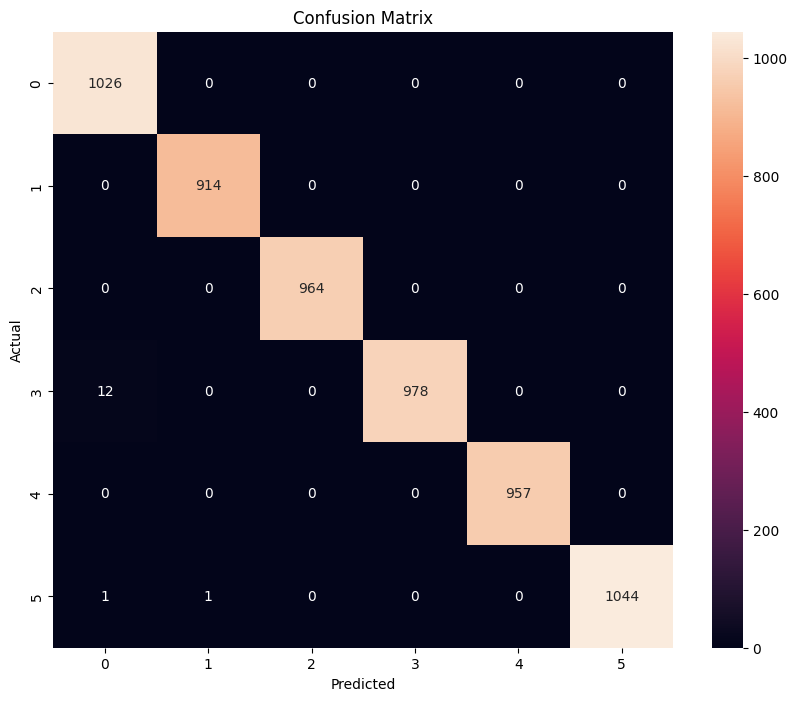

In [26]:
conf_matrix = confusion_matrix(test_labels, test_preds_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [27]:
class_report = classification_report(test_labels, test_preds_classes, target_names=cls)
print('Classification Report:\n', class_report)

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.99      1.00      0.99      1026
   BreastMRI       1.00      1.00      1.00       914
         CXR       1.00      1.00      1.00       964
     ChestCT       1.00      0.99      0.99       990
        Hand       1.00      1.00      1.00       957
      HeadCT       1.00      1.00      1.00      1046

    accuracy                           1.00      5897
   macro avg       1.00      1.00      1.00      5897
weighted avg       1.00      1.00      1.00      5897



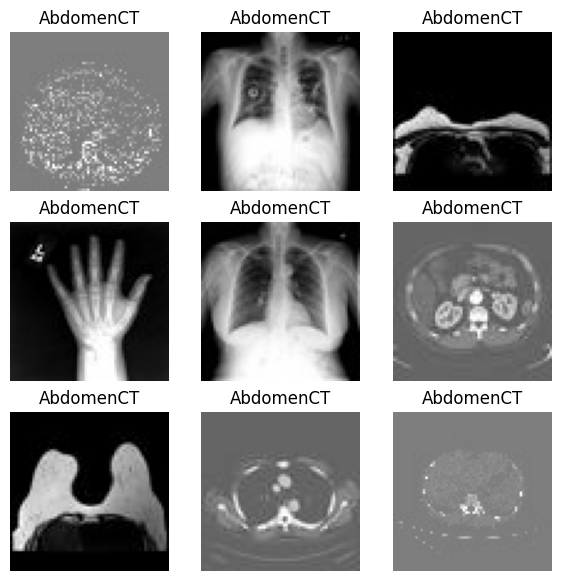

In [28]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(cls[np.argmax(labels[i])])
        plt.axis('off')
plt.show()

In [29]:
def classify_img(image_path):
    ip_img = tf.keras.utils.load_img(image_path,target_size = (64,64))
    ip_img_arr = tf.keras.utils.img_to_array(ip_img)
    ip_img_exp_dim = tf.expand_dims(ip_img_arr,0)
    
    pred = model.predict(ip_img_exp_dim)
    result = tf.nn.softmax(pred[0])
    outcome = "The image belongs to " + cls[np.argmax(result)]
    return outcome

In [30]:
classify_img("medical_mnist/HeadCT/000037.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


'The image belongs to HeadCT'